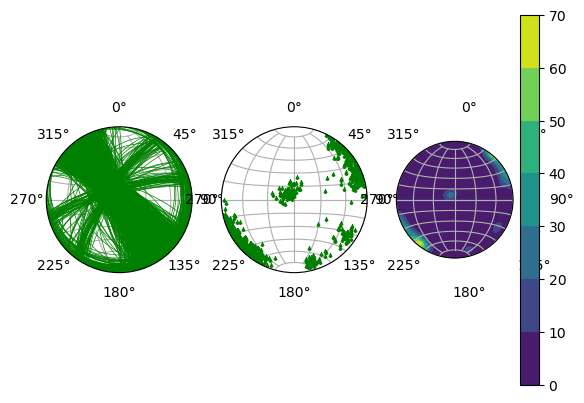

In [10]:
import sphstat as ss
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplstereonet

data = pd.read_csv('frac_attitude_data.csv')
strike = data['DipDir_'] + 90 %360
dip = data['Dip']

fig = plt.figure()

ax_1 = fig.add_subplot(131, projection='stereonet')
ax_1.grid()
ax_1.plane(strike , dip, 'g-', linewidth=.5)

ax_2 = fig.add_subplot(132, projection='stereonet')
ax_2.grid()
ax_2.pole(strike, dip, 'g^', markersize=2)

ax_3 = fig.add_subplot(133, projection='stereonet')

cax = ax_3.density_contourf(strike, dip, measurement='poles')
ax_3.grid(True)
fig.colorbar(cax)

plt.show()